# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit
8. Model Interpretability with Shapley Values 


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import aequitas as ae
import shap

from sklearn.metrics import (brier_score_loss, accuracy_score, f1_score, classification_report, 
                             roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, 
                             confusion_matrix)

from utils import (build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, 
                   posterior_mean_field, prior_trainable)

from student_utils import (reduce_dimension_ndc, select_first_encounter, patient_dataset_splitter, 
                           create_tf_categorical_feature_cols, create_tf_numeric_feature, 
                           get_mean_std_from_preds, get_student_binary_prediction)


%load_ext autoreload
%autoreload

pd.set_option('display.max_columns', 500)
plt.rcParams.update({'font.size': 16})

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [2]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [3]:
df.sample(n=10, random_state=1)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
50962,116653020,18003501,Caucasian,Male,[70-80),?,6,1,17,2,?,?,428,157|427,0,1,0,82,9,18,4,47918-902,None,None,Ch,NO
126452,290605116,39950604,Caucasian,Female,[80-90),?,1,1,7,1,BC,?,813,401|331,0,1,0,32,7,7,1,NaN,None,None,No,NO
3861,18575130,3650238,AfricanAmerican,Male,[40-50),?,1,1,7,7,?,Psychiatry,295,319|250,0,3,0,40,4,7,0,47918-898,None,None,Ch,>30
81097,166174266,47569113,Caucasian,Male,[50-60),?,1,11,7,8,MC,?,518,491|428,0,0,0,68,9,20,3,47918-902,None,Norm,Ch,NO
11635,39283440,77756274,Caucasian,Male,[50-60),?,6,1,17,1,?,Cardiology,433,250.41|403,0,0,0,66,7,29,1,68084-458,None,None,No,>30
30419,78524136,25001469,Caucasian,Male,[40-50),?,6,25,17,2,?,?,486,491|250.01,0,0,0,23,4,12,0,47918-898,>200,None,Ch,NO
47996,110072892,2351223,?,Male,[60-70),?,1,1,6,7,UN,?,491,486|428,0,1,0,45,5,16,0,47918-898,None,None,Ch,NO
42699,101843496,99108252,Caucasian,Female,[70-80),?,3,3,1,4,?,?,715,428|496,0,0,0,45,9,27,2,0781-5421,None,Norm,No,NO
129702,317264726,1123920,Caucasian,Female,[70-80),?,5,1,1,1,?,InternalMedicine,413,413|426,0,0,0,21,6,14,3,65862-671,None,None,Ch,NO
78805,163306482,61119315,Caucasian,Female,[80-90),?,1,6,7,4,?,?,786,496|250,0,0,0,33,8,16,1,51655-120,None,None,Ch,NO


## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [4]:
print(f'Number of unique patient_ids: {df.patient_nbr.nunique()}.')

Number of unique patient_ids: 71518.


In [5]:
print(f'Number of unique encounter_ids: {df.encounter_id.nunique()}.')

Number of unique encounter_ids: 101766.


In [6]:
print(f'Number of entries in the dataset: {len(df)}.')

Number of entries in the dataset: 143424.


- As the number of entries is larger then the number of unique encounter IDs in the dataset, the dataset is on the line level.
- The 'ndc_code' could be aggregated according to API.
- The 'primary_diagnosis_code' should be groupped or embedded

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


In [7]:
# Number of missing values
df = df.replace('?', np.nan)
df.sample(n=10, random_state=1)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
50962,116653020,18003501,Caucasian,Male,[70-80),NaN,6,1,17,2,NaN,NaN,428,157|427,0,1,0,82,9,18,4,47918-902,None,None,Ch,NO
126452,290605116,39950604,Caucasian,Female,[80-90),NaN,1,1,7,1,BC,NaN,813,401|331,0,1,0,32,7,7,1,NaN,None,None,No,NO
3861,18575130,3650238,AfricanAmerican,Male,[40-50),NaN,1,1,7,7,NaN,Psychiatry,295,319|250,0,3,0,40,4,7,0,47918-898,None,None,Ch,>30
81097,166174266,47569113,Caucasian,Male,[50-60),NaN,1,11,7,8,MC,NaN,518,491|428,0,0,0,68,9,20,3,47918-902,None,Norm,Ch,NO
11635,39283440,77756274,Caucasian,Male,[50-60),NaN,6,1,17,1,NaN,Cardiology,433,250.41|403,0,0,0,66,7,29,1,68084-458,None,None,No,>30
30419,78524136,25001469,Caucasian,Male,[40-50),NaN,6,25,17,2,NaN,NaN,486,491|250.01,0,0,0,23,4,12,0,47918-898,>200,None,Ch,NO
47996,110072892,2351223,NaN,Male,[60-70),NaN,1,1,6,7,UN,NaN,491,486|428,0,1,0,45,5,16,0,47918-898,None,None,Ch,NO
42699,101843496,99108252,Caucasian,Female,[70-80),NaN,3,3,1,4,NaN,NaN,715,428|496,0,0,0,45,9,27,2,0781-5421,None,Norm,No,NO
129702,317264726,1123920,Caucasian,Female,[70-80),NaN,5,1,1,1,NaN,InternalMedicine,413,413|426,0,0,0,21,6,14,3,65862-671,None,None,Ch,NO
78805,163306482,61119315,Caucasian,Female,[80-90),NaN,1,6,7,4,NaN,NaN,786,496|250,0,0,0,33,8,16,1,51655-120,None,None,Ch,NO


In [8]:
df.isna().sum()

encounter_id                     0
patient_nbr                      0
race                          3309
gender                           0
age                              0
weight                      139122
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                   54190
medical_specialty            69463
primary_diagnosis_code          33
other_diagnosis_codes            0
number_outpatient                0
number_inpatient                 0
number_emergency                 0
num_lab_procedures               0
number_diagnoses                 0
num_medications                  0
num_procedures                   0
ndc_code                     23462
max_glu_serum                    0
A1Cresult                        0
change                           0
readmitted                       0
dtype: int64

##### Fields with high amount of missing values: 
- weight
- medical_specialty
- payer_code
- ndc_code

In [9]:
# Checking data types 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      140115 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    4302 non-null    object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                89234 non-null   object
 11  medical_specialty         73961 non-null   object
 12  primary_diagnosis_code    143391 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

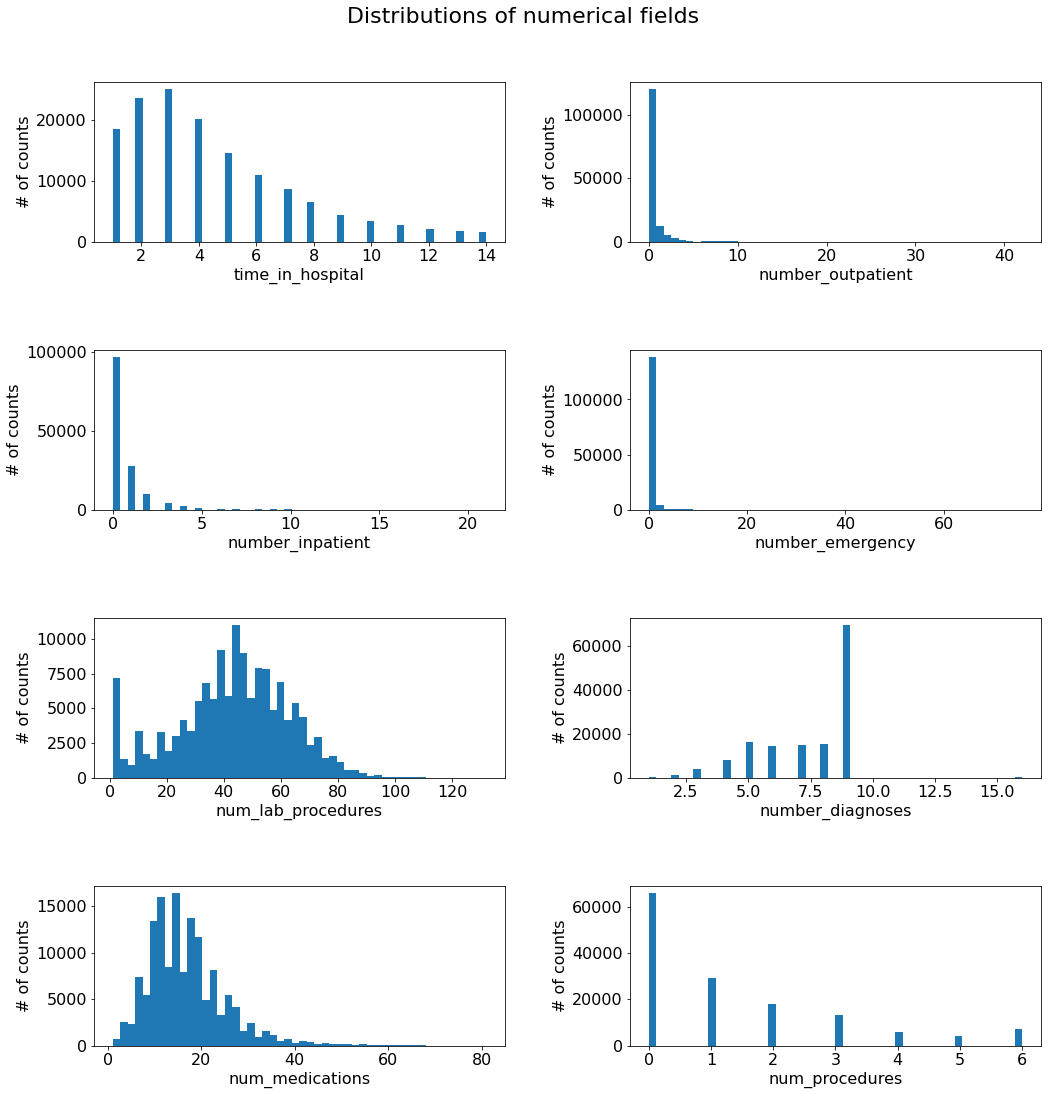

In [10]:
# Numerical fields and their distributions
numerical_fields = ['time_in_hospital', 'number_outpatient', 'number_inpatient', 'number_emergency', 
                    'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']

fig, axs = plt.subplots(4,2, figsize=(16,16))
fig.suptitle("Distributions of numerical fields", fontsize=22, y = 0.99, x = 0.47)
fig.tight_layout(pad=5.0)


for field, plot in zip(numerical_fields, axs.flatten()):
    plot.hist(df.loc[:, field], bins=50)
    plot.set_xlabel(field)
    plot.set_ylabel('# of counts')

##### Following fields have Gaussian distribution:
- time in the hospital (positively skewed)
- num_lab_procedures
- num_medications (positively skewed)

In [11]:
# Categorical features: cardinality
categorical_fields = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                     'payer_code', 'medical_specialty', 'primary_diagnosis_code', 'other_diagnosis_codes', 
                     'ndc_code', 'max_glu_serum','A1Cresult', 'change']

categorical_fields_cardinality = []

print('Cardinality of fields:')

for field in categorical_fields:
    cardinality = df.loc[:, field].nunique()
    categorical_fields_cardinality.append(cardinality)
    print(f'{field} : {cardinality}')

Cardinality of fields:
race : 5
gender : 3
admission_type_id : 8
discharge_disposition_id : 26
admission_source_id : 17
payer_code : 17
medical_specialty : 72
primary_diagnosis_code : 716
other_diagnosis_codes : 19374
ndc_code : 251
max_glu_serum : 4
A1Cresult : 4
change : 2


##### Following fields exhibit high degree of cardinality:
- other_diagnosis_codes: 19 374
- primary_diagnosis_code : 716
- ndc_code : 251
- medical_specialty : 72

The fields with medical codes, have many unique values as the diagnosis can vary vastly across the patients, as well as patient can have many different drugs administered.

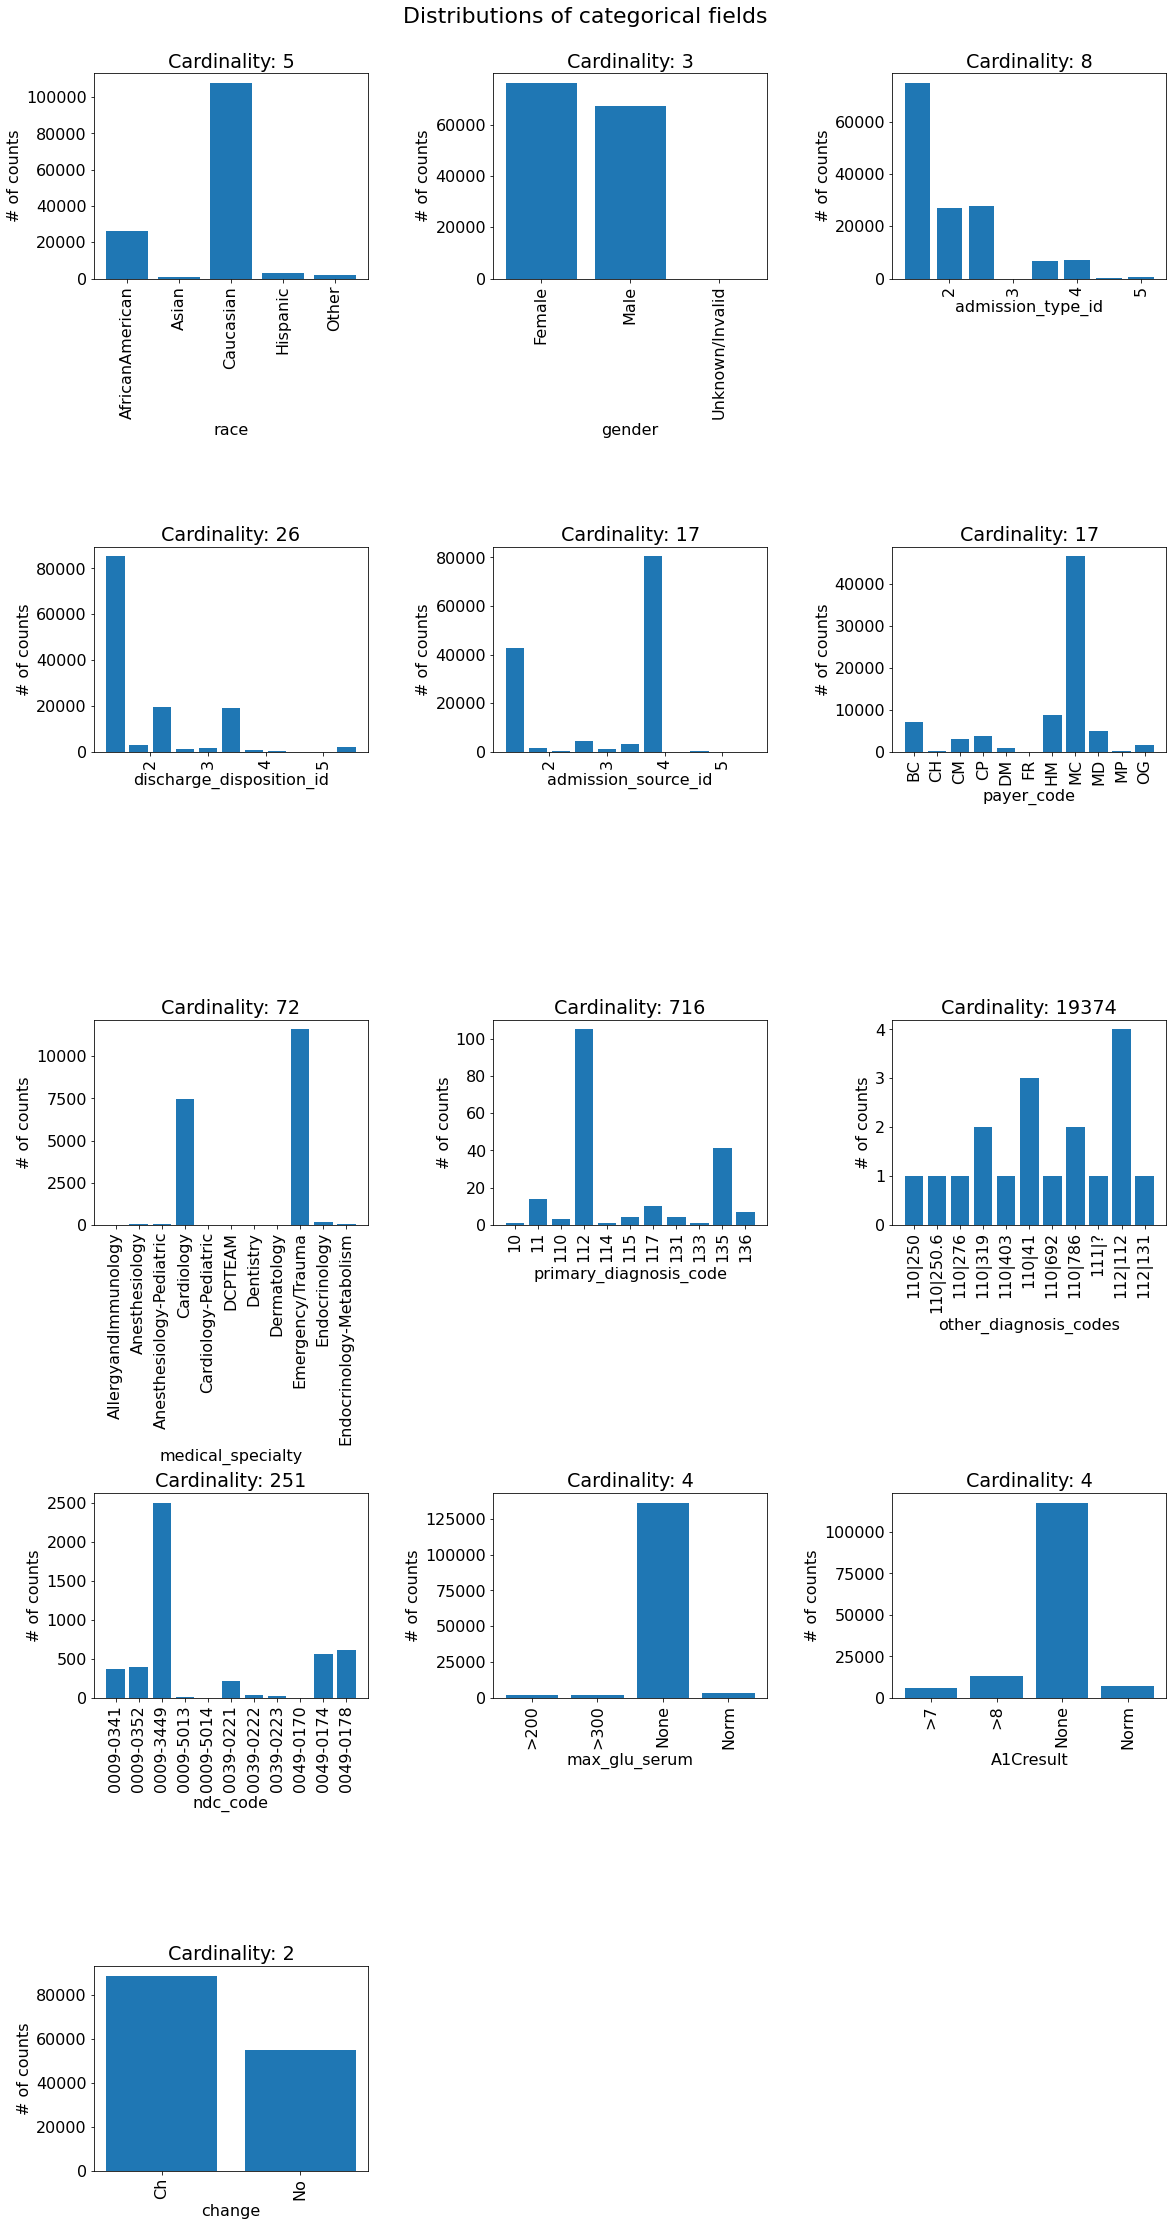

In [12]:
# Categorical fields and their distributions
fig, axs = plt.subplots(5,3, figsize=(16,30))
fig.suptitle("Distributions of categorical fields", fontsize=22, y = 1.02, x = 0.47)
fig.tight_layout(h_pad=15.0, w_pad=5.0)

subplots_number = len(axs.flatten())


for field, cardinality, plot in zip(categorical_fields, categorical_fields_cardinality, axs.flatten()):
    value_counts = df.loc[:, field].value_counts().sort_index()
    
    if cardinality < 10:
        plot.bar(value_counts.index, value_counts)
        
    else:
        plot.bar(value_counts.index[0:11], value_counts[0:11])
    
    
    plot.set_title(f'Cardinality: {cardinality}')
    plot.set_xlabel(field)
    plot.set_ylabel('# of counts')
    plot.set_xticklabels(value_counts.index, rotation = 90)
    
        
for i, plot in enumerate(axs.flatten()):
    if i >= len(categorical_fields):
        plot.axis('off')

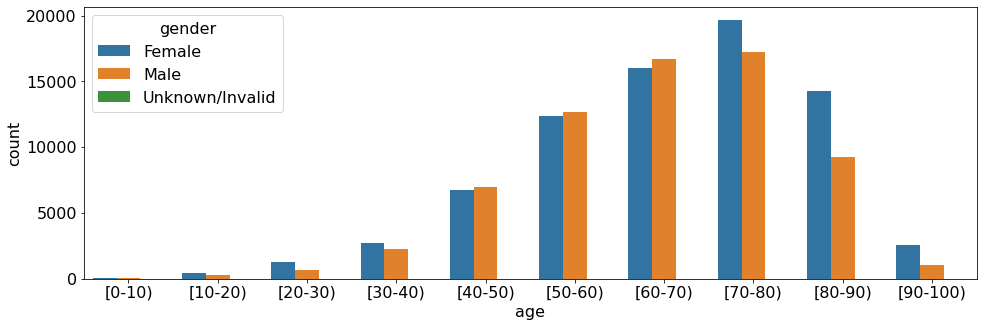

In [13]:
plt.figure(figsize=(16,5))
sns.countplot(x='age', hue='gender', data=df)
plt.show()

The distribution of age is Gaussian negatively skewed for both genders.
There are more female patients in the dataset.

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

In [14]:
######NOTE: The visualization will only display in Chrome browser. ########
# full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
# tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [15]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [16]:
ndc_code_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   NDC_Code              269 non-null    object
 1   Proprietary Name      269 non-null    object
 2   Non-proprietary Name  269 non-null    object
 3   Dosage Form           267 non-null    object
 4   Route Name            264 non-null    object
 5   Company Name          267 non-null    object
 6   Product Type          267 non-null    object
dtypes: object(7)
memory usage: 14.8+ KB


In [17]:
set(df['ndc_code']).issubset(set(ndc_code_df['NDC_Code'])) 

False

In [18]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide


In [19]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [20]:
patients = reduce_dim_df['patient_nbr'].unique()
len(patients)

71518

In [21]:
reduce_dim_df['patient_nbr'].value_counts()

90609804     52
89472402     51
91751121     50
62352252     46
84397842     41
             ..
29758446      1
136005512     1
2291436       1
101885670     1
2873403       1
Name: patient_nbr, Length: 71518, dtype: int64

In [22]:
first_encounter_df = select_first_encounter(reduce_dim_df)

In [23]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


In [24]:
first_encounter_df.to_pickle('First_encounter_df.pkl')

## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [25]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
grouping_field_list

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures',
 'ndc_code',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'readmitted']

In [26]:
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [27]:
agg_drug_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glyburide,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate
0,88792836,100654011,Caucasian,Female,[70-80),[75-100),3,3,1,10,UN,Surgery-General,715,402|428,1,3,1,65,9,28,1,0049-4110,None,None,Ch,<30,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0
1,88986678,58682736,Caucasian,Male,[80-90),[50-75),1,11,5,6,UN,Family/GeneralPractice,250.2,780|403,0,0,0,73,9,16,0,68071-1701,None,None,No,NO,[Human Insulin],0,0,0,0,1,0,0,0,0,0,0,0
2,89032962,69250302,Caucasian,Male,[60-70),[100-125),1,1,7,2,CP,Cardiology,414,411|401,0,0,0,58,9,12,3,0781-5422,None,None,No,>30,[Pioglitazone],0,0,0,0,0,0,0,0,0,1,0,0
3,89277516,30950811,Caucasian,Male,[50-60),[100-125),3,1,1,2,BC,Surgery-General,196,199|250,0,0,0,5,7,11,4,0093-8342,None,None,No,>30,[Glyburide],0,0,0,1,0,0,0,0,0,0,0,0
4,89307582,58763808,Caucasian,Female,[70-80),[75-100),1,3,7,10,MC,InternalMedicine,250.4,403|276,0,0,0,63,9,20,0,0591-0460,None,None,No,<30,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0


In [28]:
len(agg_drug_df)

591

In [29]:
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glyburide',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Nateglinide',
 'Pioglitazone',
 'Repaglinide',
 'Rosiglitazone_Maleate']

In [30]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [31]:
agg_drug_df.to_pickle('Agg_drug_df.pkl')

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

In [32]:
agg_drug_df.weight.value_counts()

[75-100)     239
[50-75)      156
[100-125)    128
[125-150)     36
[25-50)       14
[150-175)     11
[0-25)         4
[175-200)      3
Name: weight, dtype: int64

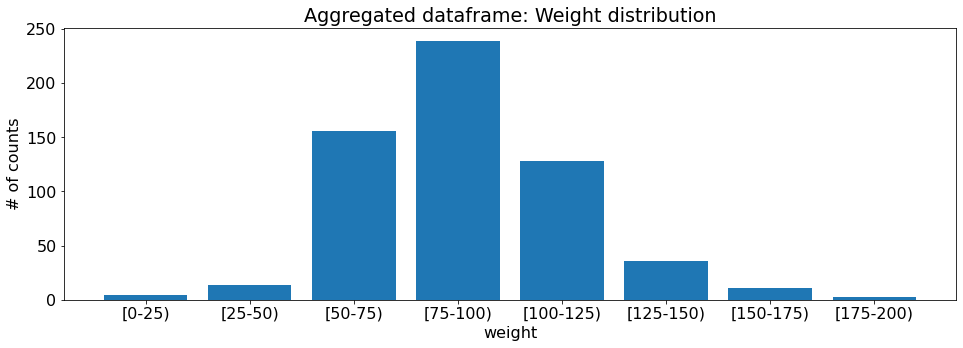

In [33]:
weight_buckets = ['[0-25)', '[25-50)', '[50-75)', '[75-100)', '[100-125)', '[125-150)', '[150-175)', '[175-200)']
weight_values = [4, 14, 156, 239, 128, 36, 11, 3]

plt.figure(figsize=(16,5))

plt.bar(weight_buckets, weight_values)
plt.title('Aggregated dataframe: Weight distribution')
plt.xlabel('weight')
plt.ylabel('# of counts')
plt.show()

In [34]:
agg_drug_df.isna().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
primary_diagnosis_code      0
other_diagnosis_codes       0
number_outpatient           0
number_inpatient            0
number_emergency            0
num_lab_procedures          0
number_diagnoses            0
num_medications             0
num_procedures              0
ndc_code                    0
max_glu_serum               0
A1Cresult                   0
change                      0
readmitted                  0
generic_drug_name_array     0
Acarbose                    0
Glimepiride                 0
Glipizide                   0
Glyburide                   0
Human_Insulin               0
Insulin_Human               0
Metformin_

- in the aggregated dataframe there are no missing values, the features will be chosen on the basis of demographic analysis for the aggregated dataframe

In [35]:
agg_drug_df_age = agg_drug_df.age.value_counts().sort_index()
agg_drug_df_age

[10-20)       4
[20-30)       8
[30-40)      16
[40-50)      38
[50-60)      96
[60-70)     153
[70-80)     175
[80-90)      86
[90-100)     15
Name: age, dtype: int64

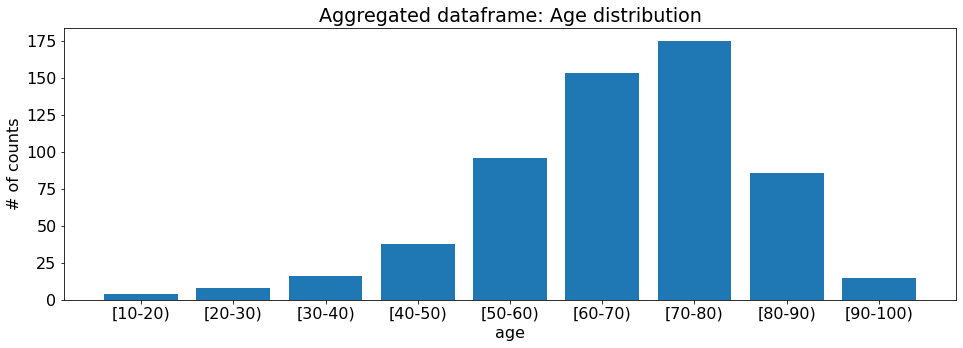

In [36]:
plt.figure(figsize=(16,5))

plt.bar(agg_drug_df_age.index, agg_drug_df_age)
plt.title('Aggregated dataframe: Age distribution')
plt.xlabel('age')
plt.ylabel('# of counts')
plt.show()

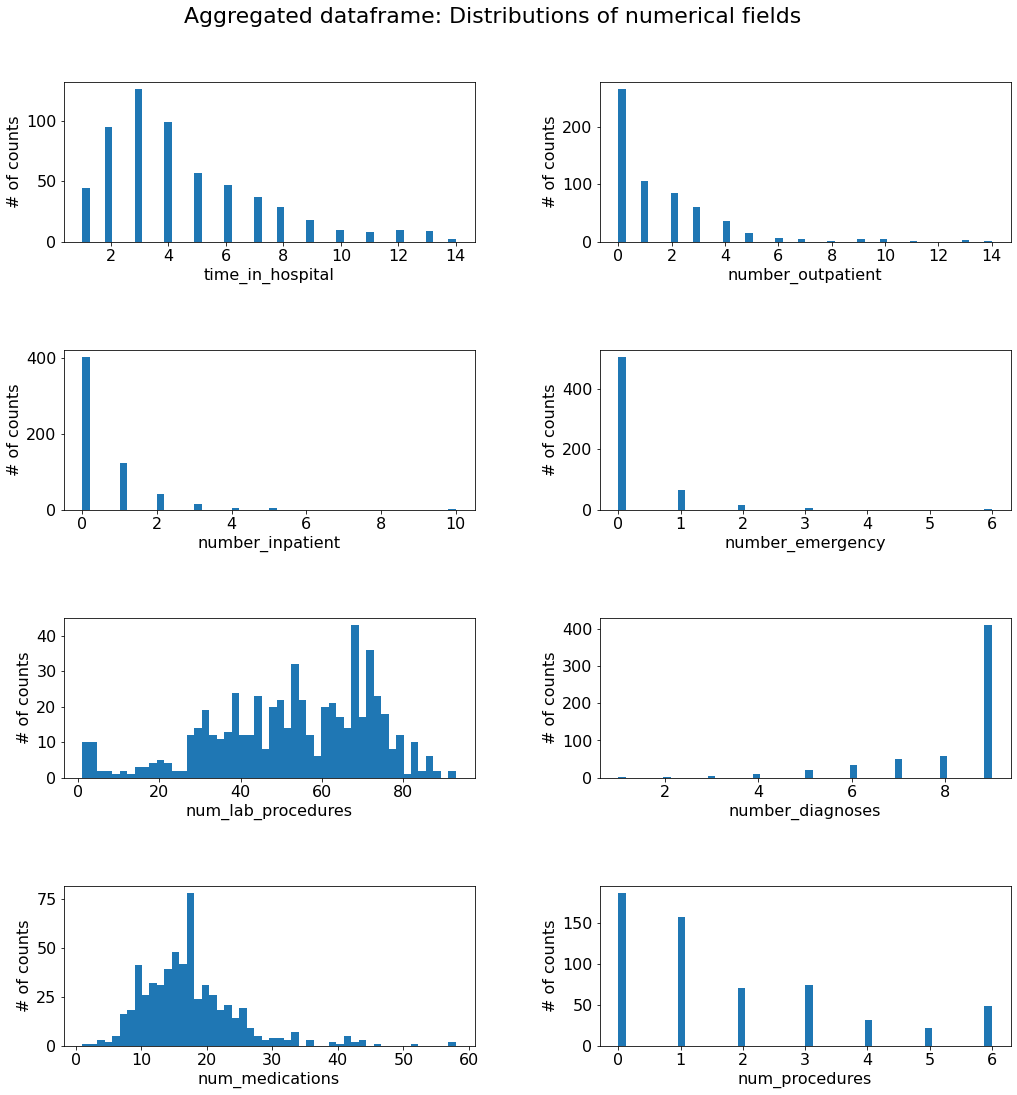

In [37]:
# Numerical fields and their distributions
# numerical_fields = ['time_in_hospital', 'number_outpatient', 'number_inpatient', 'number_emergency', 
#                     'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']

fig, axs = plt.subplots(4,2, figsize=(16,16))
fig.suptitle("Aggregated dataframe: Distributions of numerical fields", fontsize=22, y = 0.99, x = 0.47)
fig.tight_layout(pad=5.0)


for field, plot in zip(numerical_fields, axs.flatten()):
    plot.hist(agg_drug_df.loc[:, field], bins=50)
    plot.set_xlabel(field)
    plot.set_ylabel('# of counts')

In [38]:
agg_df_categorical_fields_cardinality = []

print('Cardinality of fields:')

for field in categorical_fields:
    cardinality = agg_drug_df.loc[:, field].nunique()
    agg_df_categorical_fields_cardinality.append(cardinality)
    print(f'{field} : {cardinality}')

Cardinality of fields:
race : 4
gender : 2
admission_type_id : 4
discharge_disposition_id : 10
admission_source_id : 6
payer_code : 10
medical_specialty : 7
primary_diagnosis_code : 156
other_diagnosis_codes : 434
ndc_code : 125
max_glu_serum : 1
A1Cresult : 4
change : 2


Value_counts: race
AfricanAmerican     21
Asian                1
Caucasian          561
Other                8
Name: race, dtype: int64


Value_counts: gender
Female    299
Male      292
Name: gender, dtype: int64


Value_counts: admission_type_id
1    287
2    101
3    202
5      1
Name: admission_type_id, dtype: int64


Value_counts: discharge_disposition_id
1     388
2       3
3      73
4       3
5       5
6     107
7       2
11      4
13      5
18      1
Name: discharge_disposition_id, dtype: int64


Value_counts: admission_source_id
1     281
4      12
5      22
6      17
7     258
17      1
Name: admission_source_id, dtype: int64


Value_counts: payer_code
BC     48
CM     28
CP     43
DM     31
HM     32
MC    288
MD      7
SP      4
UN    108
WC      2
Name: payer_code, dtype: int64


Value_counts: medical_specialty
Cardiology                 205
Family/GeneralPractice      49
InternalMedicine           146
ObstetricsandGynecology     17
Pediatrics                   3
Psychiatr

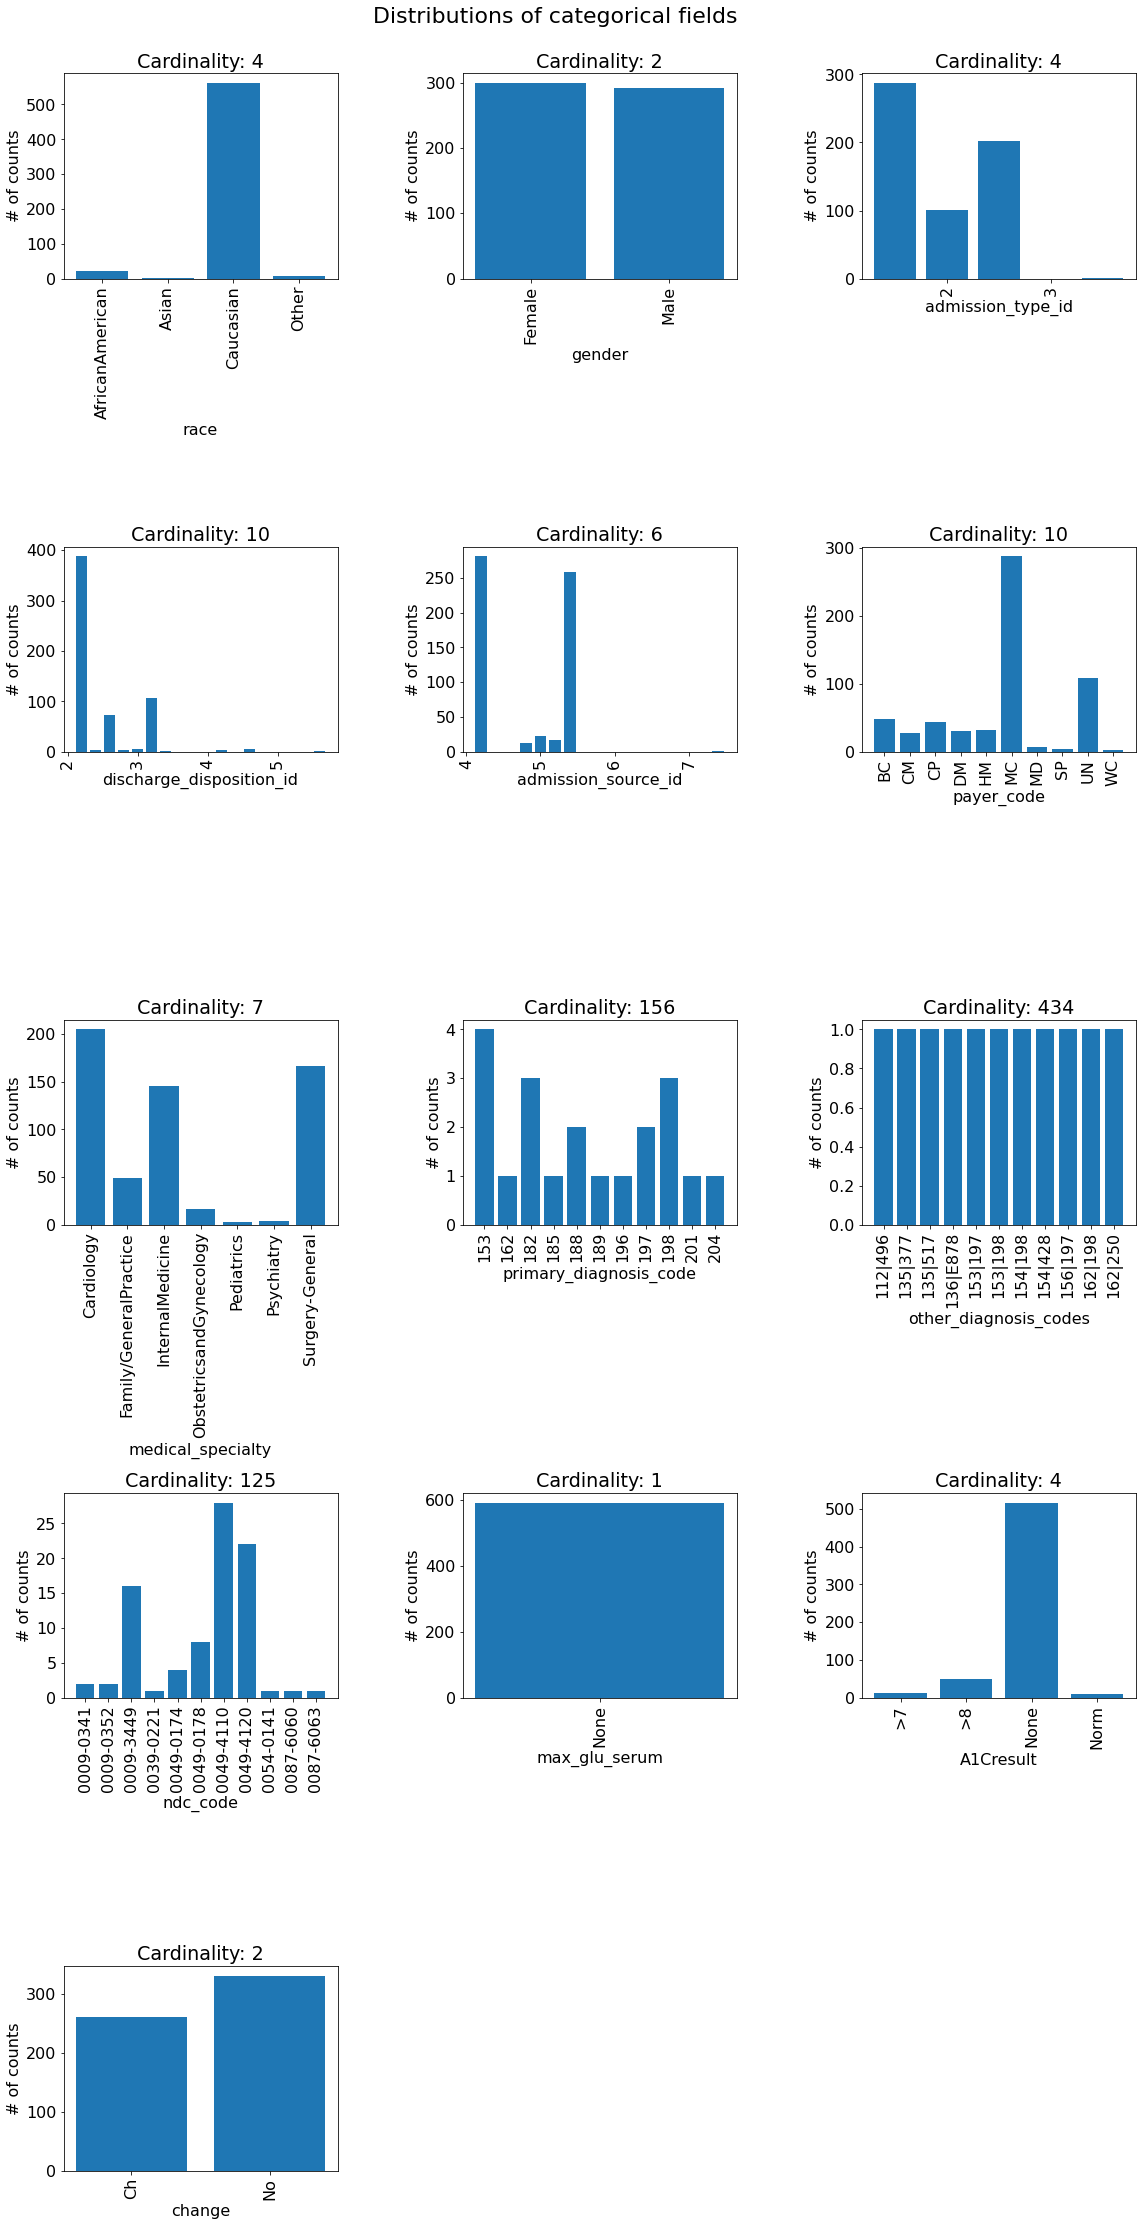

In [39]:
fig, axs = plt.subplots(5,3, figsize=(16,30))
fig.suptitle("Distributions of categorical fields", fontsize=22, y = 1.02, x = 0.47)
fig.tight_layout(h_pad=15.0, w_pad=5.0)


for field, cardinality, plot in zip(categorical_fields, agg_df_categorical_fields_cardinality, axs.flatten()):
    value_counts = agg_drug_df.loc[:, field].value_counts().sort_index()
    print('Value_counts: ' + field)
    print(value_counts)
    print('\n')
    
    if cardinality < 10:
        plot.bar(value_counts.index, value_counts)
        
    else:
        plot.bar(value_counts.index[0:11], value_counts[0:11])
    
    
    plot.set_title(f'Cardinality: {cardinality}')
    plot.set_xlabel(field)
    plot.set_ylabel('# of counts')
    plot.set_xticklabels(value_counts.index, rotation = 90)
    
for i, plot in enumerate(axs.flatten()):
    if i >= len(categorical_fields):
        plot.axis('off')

##### Feature selection:

###### Categorical features:
- 'weight' field of the aggragated dataframe has no NaN values and a Gaussian distribution. It is  an important parameter for estimation of health condition of diabetic patients. This is why it will be used as a feature.
- 'payer_code', 'medical_specialty' will be omitted, as it is not decisive feature for the length of hospital stay
- 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'change' will be used as features
- 'primary_diagnosis_code' will be used in the model, as it is a decisive feature. As its cardinality amounts to 156, it will be represented as embedded column.
- 'other_diagnosis_codes' will be omitted as its cardinality amounts to 434 and is not as decisive as 'primary_diagnosis_code'
- 'max_glu_serum' will be omitted, as the cardinality amounts to 1.
- 'A1Cresults' will be omitted as most of the values are of category 'None'

###### Numerical features:
- 'number_outpatient', 'number_inpatient', 'number_emergency' will not be used as features, as those do not have a decisive impact on the length of the hospital stay, additionally their distribution is not normal.
- 'number_diagnoses' will not be used, as we focus on the primary diagnosis, additionally their distribution is not normal.
- 'num_medications' will not be used, as it is already included in the ndc_col dummy features
- 'num_lab_procedures' and 'num_procedures' will be used, as those have an impact on the length of the hospital stay

In [40]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = [ 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                               'change'] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ['num_lab_procedures',
                             'num_procedures']
PREDICTOR_FIELD = 'time_in_hospital'

In [41]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [42]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)
selected_features_df.head()

,patient_nbr,time_in_hospital,weight,admission_type_id,discharge_disposition_id,admission_source_id,change,race,gender,age,Acarbose,Glimepiride,Glipizide,Glyburide,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,num_lab_procedures,num_procedures
0,100654011,10,[75-100),3,3,1,Ch,Caucasian,Female,[70-80),0,0,1,0,0,0,0,0,0,0,0,0,65,1
1,58682736,6,[50-75),1,11,5,No,Caucasian,Male,[80-90),0,0,0,0,1,0,0,0,0,0,0,0,73,0
2,69250302,2,[100-125),1,1,7,No,Caucasian,Male,[60-70),0,0,0,0,0,0,0,0,0,1,0,0,58,3
3,30950811,2,[100-125),3,1,1,No,Caucasian,Male,[50-60),0,0,0,1,0,0,0,0,0,0,0,0,5,4
4,58763808,10,[75-100),1,3,7,No,Caucasian,Female,[70-80),0,0,1,0,0,0,0,0,0,0,0,0,63,0


### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [43]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [44]:
processed_df.equals(selected_features_df)

True

- As there are no NaN values in the 'selected_features_df' there are no issues with casting and imputing.

In [45]:
processed_df.to_pickle('Processed_df.pkl')

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [46]:
# this is on the basis of my Pneumonia detection project:
## https://github.com/SylwiaNowakowska/Chest_X_ray_Pneumonia_detection/blob/main/2%20Build%20and%20train%20model.ipynb
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [47]:
train_patient_ids = d_train['patient_nbr'].unique()
valid_patient_ids = d_val['patient_nbr'].unique()
test_patient_ids = d_test['patient_nbr'].unique()

print(f'Patient ID overlap between train and valid datasets: {np.intersect1d(np.unique(train_patient_ids), np.unique(valid_patient_ids))}') 
print(f'Patient ID overlap between train and test datasets: {np.intersect1d(np.unique(train_patient_ids), np.unique(test_patient_ids))}')
print(f'Patient ID overlap between valid and test datasets: {np.intersect1d(np.unique(valid_patient_ids), np.unique(test_patient_ids))}')

Patient ID overlap between train and valid datasets: []
Patient ID overlap between train and test datasets: []
Patient ID overlap between valid and test datasets: []


In [48]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [49]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


In [50]:
d_train.to_pickle('Train_df.pkl')
d_val.to_pickle('Val_df.pkl')
d_test.to_pickle('Test_df.pkl')

## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

In [51]:
def split_stats_visualization(column, df_list, df_names, colors):
    fig, ax = plt.subplots(2,2, figsize=(16,12))
    fig.suptitle(f'{column}: distribution', fontsize=22, y = 1, x = 0.52)

    for df, df_name, color, plot in zip(df_list, df_names, colors, ax.flatten()):
        value_counts = df[column].value_counts().sort_index()
        plot.bar(value_counts.index, value_counts, color=color)
        plot.set_title(df_name)
        plot.set_xlabel(column)
        plot.set_ylabel('# of counts')
        plot.set_xticklabels(value_counts.index, rotation = 90)

    fig.tight_layout(pad=2.0)

In [52]:
df_list = [processed_df, d_train, d_val, d_test]
df_names = ['Processed df', 'Training df', 'Validation df', 'Test df']
colors = ['blue', 'red', 'green', 'magenta']

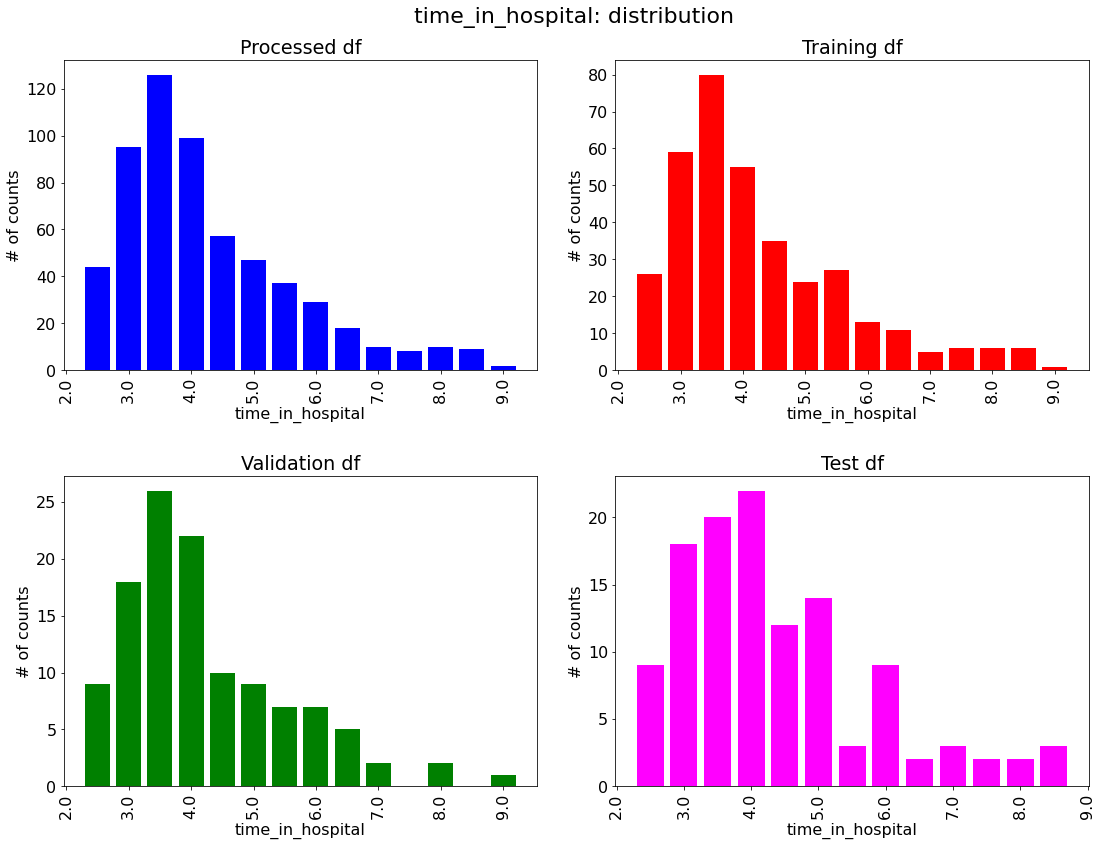

In [53]:
split_stats_visualization(PREDICTOR_FIELD, df_list, df_names, colors)

- The time_in_hospital distribution shapes are similar across the partitions.

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

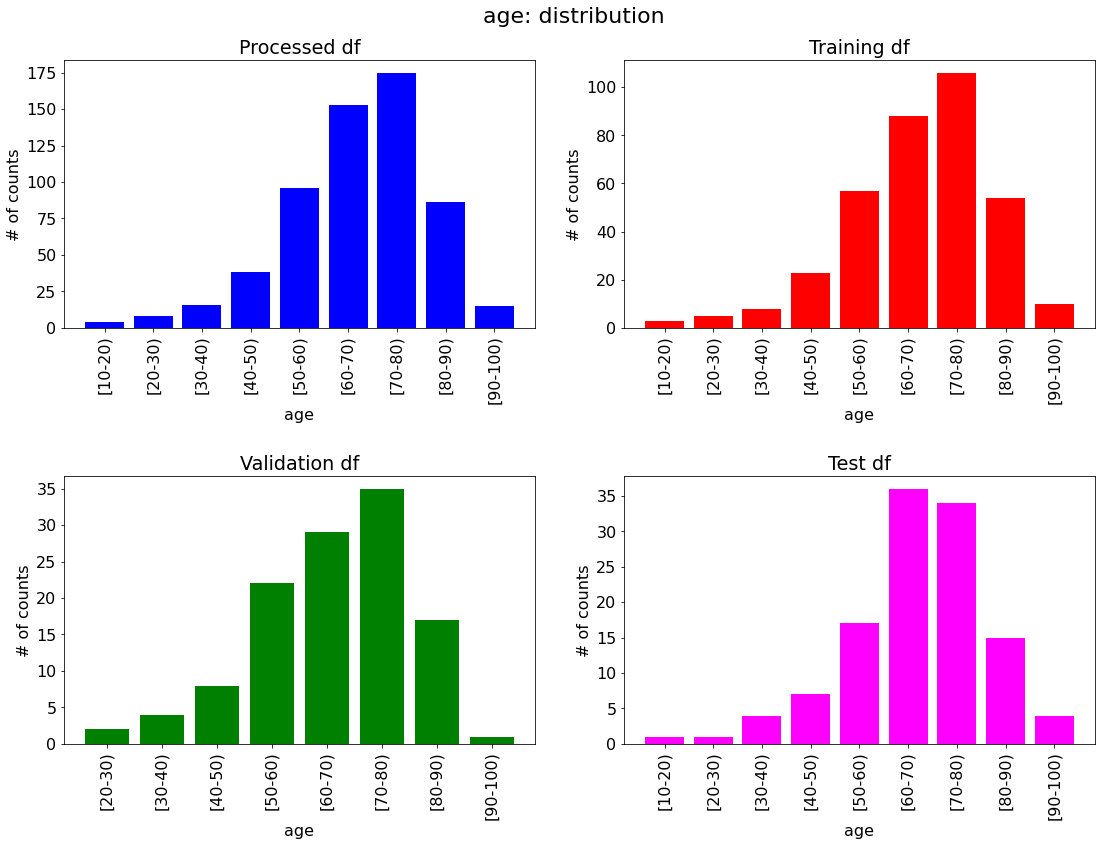

In [54]:
split_stats_visualization('age', df_list, df_names, colors)

- Age distribution is very similar across the partitions

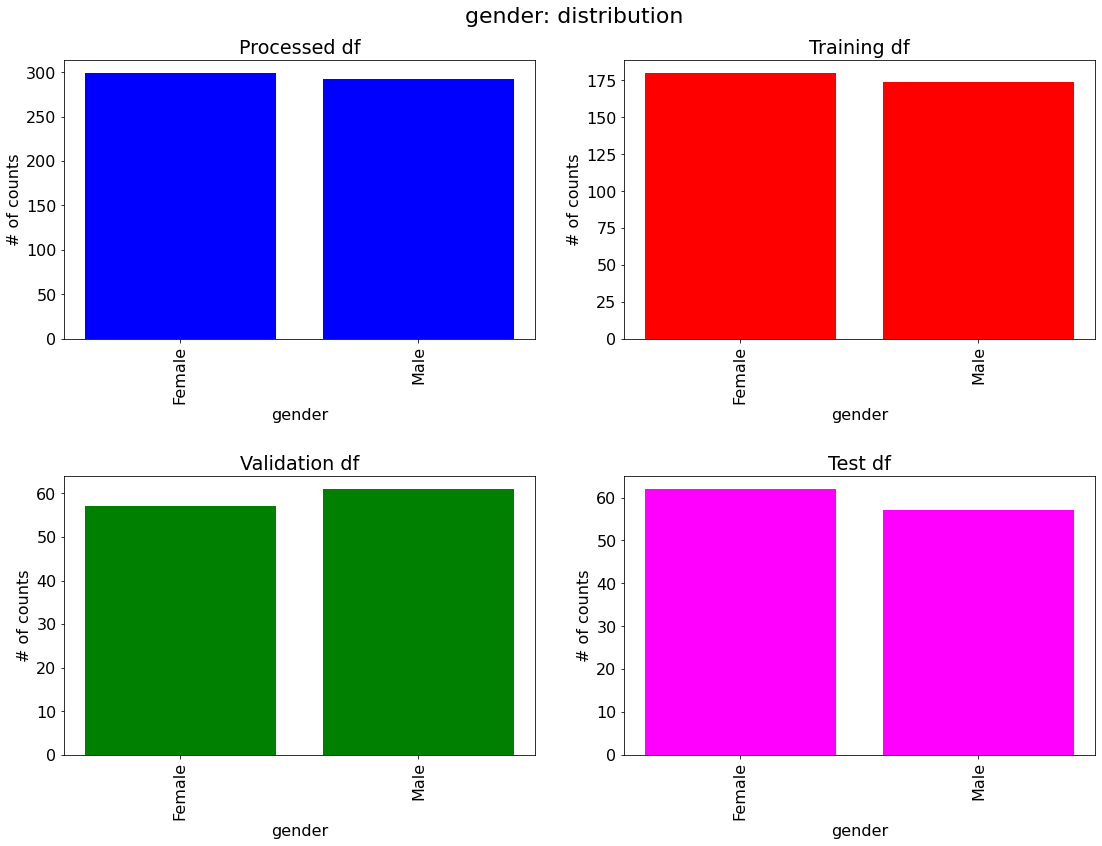

In [55]:
split_stats_visualization('gender', df_list, df_names, colors)

- The Male/Female ratio is similar in the df before splitting, in test and train partitions. The ratio differs slightly in the validation partition.

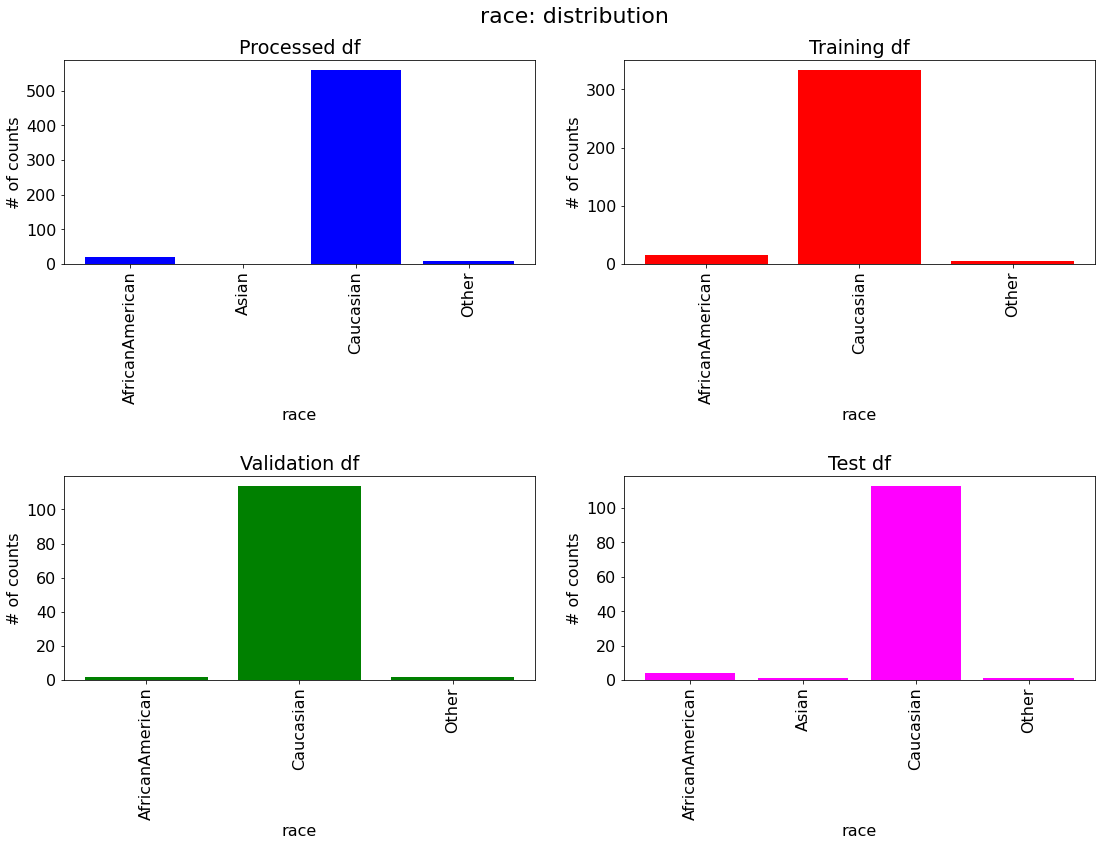

In [56]:
split_stats_visualization('race', df_list, df_names, colors)

- In all partitions Caucasian race is highly dominant in all datasets.

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [58]:
d_train = pd.read_pickle('Train_df.pkl')
d_val = pd.read_pickle('Val_df.pkl')
d_test = pd.read_pickle('Test_df.pkl')

In [59]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [60]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [61]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [62]:
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 9 in weight is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/weight_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 10 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferr

In [63]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='weight', vocabulary_file='./diabetes_vocab/weight_vocab.txt', vocabulary_size=9, num_oov_buckets=0, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(128, 9), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [64]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [65]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [66]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7ff05b20f440>, mean=52.32768361581921, std=19.308439398691235))

tf.Tensor(
[[ 1.1052631 ]
 [ 0.31578946]
 [-2.4736843 ]
 [ 0.57894737]
 [-0.31578946]
 [-0.10526316]
 [-0.10526316]
 [ 0.68421054]
 [ 0.47368422]
 [ 0.94736844]
 [ 1.        ]
 [ 0.8947368 ]
 [ 0.7368421 ]
 [ 1.        ]
 [ 0.        ]
 [-0.2631579 ]
 [-0.15789473]
 [ 1.        ]
 [ 1.4736842 ]
 [ 0.6315789 ]
 [ 0.15789473]
 [-2.1052632 ]
 [-0.6315789 ]
 [ 1.3157895 ]
 [ 1.        ]
 [-0.8947368 ]
 [-0.10526316]
 [ 0.84210527]
 [-1.5789474 ]
 [ 0.2631579 ]
 [ 0.47368422]
 [ 0.10526316]
 [-0.31578946]
 [ 0.57894737]
 [-2.4736843 ]
 [ 1.5789474 ]
 [-0.7368421 ]
 [-1.4736842 ]
 [ 1.3684211 ]
 [-0.42105263]
 [-0.05263158]
 [-0.42105263]
 [ 0.7368421 ]
 [ 0.05263158]
 [ 0.8947368 ]
 [ 0.21052632]
 [-2.5263157 ]
 [ 0.57894737]
 [-0.578947

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [67]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [68]:
# this is on the basis of my Pneumonia detection project:
## https://github.com/SylwiaNowakowska/Chest_X_ray_Pneumonia_detection/blob/main/2%20Build%20and%20train%20model.ipynb

def plot_history(history_df):   
    """
    Function plotting the training history.
    
    Args:
        history_df (dataframe): dataframe containing training history
    """
    
    N = len(history_df)
    fig, ax = plt.subplots(1,2, figsize=(15,6))
    
    ax[0].plot(np.arange(0, N), history_df["loss"], label="train loss", color='blue')
    ax[0].plot(np.arange(0, N), history_df["val_loss"], label="valid loss", color='red')
    ax[0].set_title("Training and validation loss")
    ax[0].set_xlabel("# of epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    
    ax[1].plot(np.arange(0, N), history_df["mse"], label="train MSE", color='blue')
    ax[1].plot(np.arange(0, N), history_df["val_mse"], label="valid MSE", color='red')
    ax[1].set_title("Training and validation accuracy")
    ax[1].set_xlabel("# of epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    
    fig.tight_layout(pad=3.0)
    plt.show()

In [69]:
def build_sequential_model_1(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model


def build_sequential_model_2(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(1200, activation='relu'),
        tf.keras.layers.Dense(600, activation='relu'),
        tf.keras.layers.Dense(300, activation='relu'),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model


def build_diabetes_model(train_ds, val_ds, model, epochs=5, loss_metric='mse', optimizer='rmsprop'):
    model.compile(optimizer=optimizer, loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=30)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    history_df = pd.DataFrame(history.history)
    
    plot_history(history_df)
    
    return model, history_df

Train for 3 steps, validate for 1 steps
Epoch 1/100
3/3 [==============================] - 5s 2s/step - loss: 32.7412 - mse: 31.8157 - val_loss: 67.9189 - val_mse: 67.7809
Epoch 2/100
3/3 [==============================] - 0s 54ms/step - loss: 36.0279 - mse: 36.7146 - val_loss: 14.5972 - val_mse: 14.5077
Epoch 3/100
3/3 [==============================] - 0s 56ms/step - loss: 28.8750 - mse: 27.8265 - val_loss: 67.3517 - val_mse: 67.3401
Epoch 4/100
3/3 [==============================] - 0s 59ms/step - loss: 25.3816 - mse: 25.3448 - val_loss: 34.2804 - val_mse: 34.5260
Epoch 5/100
3/3 [==============================] - 0s 54ms/step - loss: 41.6787 - mse: 42.9333 - val_loss: 13.6071 - val_mse: 13.6799
Epoch 6/100
3/3 [==============================] - 0s 53ms/step - loss: 32.9642 - mse: 31.7682 - val_loss: 52.7550 - val_mse: 53.0851
Epoch 7/100
3/3 [==============================] - 0s 54ms/step - loss: 29.9813 - mse: 30.7032 - val_loss: 38.5187 - val_mse: 38.6036
Epoch 8/100
3/3 [=======

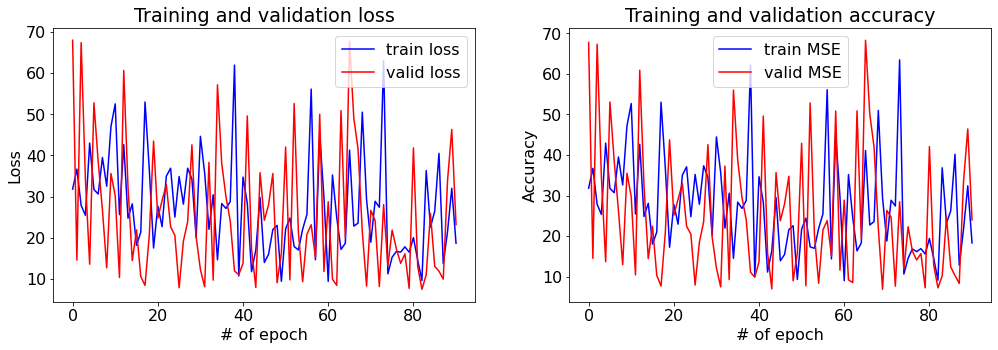

In [70]:
model_1 = build_sequential_model_1(claim_feature_layer)
diabetes_model_1, history_1 = build_diabetes_model(diabetes_train_ds, diabetes_val_ds, model=model_1, epochs=100)

- architecture with more hidden layer will be tried

Train for 3 steps, validate for 1 steps
Epoch 1/100
3/3 [==============================] - 6s 2s/step - loss: 40.1303 - mse: 42.0526 - val_loss: 75.6574 - val_mse: 75.6970
Epoch 2/100
3/3 [==============================] - 0s 102ms/step - loss: 29.8310 - mse: 30.7041 - val_loss: 604.2107 - val_mse: 604.2177
Epoch 3/100
3/3 [==============================] - 0s 105ms/step - loss: 144.6167 - mse: 149.2747 - val_loss: 18.8690 - val_mse: 18.7010
Epoch 4/100
3/3 [==============================] - 0s 104ms/step - loss: 88.6975 - mse: 84.7711 - val_loss: 15.4914 - val_mse: 15.7539
Epoch 5/100
3/3 [==============================] - 0s 107ms/step - loss: 26.5366 - mse: 27.0430 - val_loss: 9.5253 - val_mse: 9.1915
Epoch 6/100
3/3 [==============================] - 0s 104ms/step - loss: 41.9935 - mse: 43.3906 - val_loss: 43.1892 - val_mse: 42.8433
Epoch 7/100
3/3 [==============================] - 0s 107ms/step - loss: 39.6256 - mse: 41.3157 - val_loss: 32.9645 - val_mse: 32.9678
Epoch 8/100
3/3 

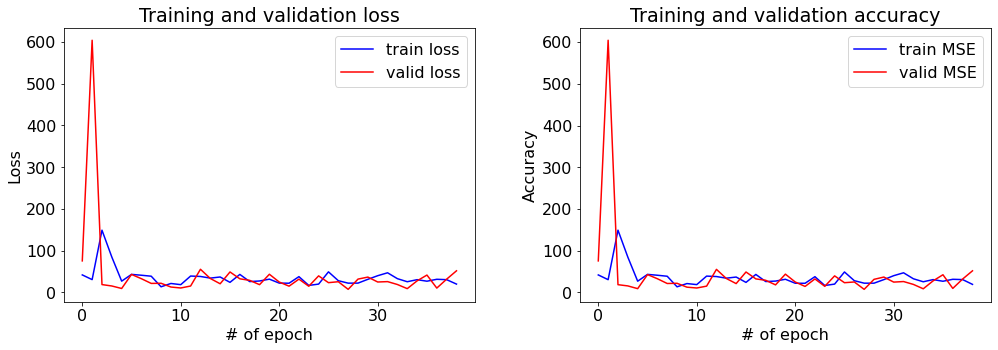

In [71]:
model_2 = build_sequential_model_2(claim_feature_layer)
diabetes_model_2, history_2 = build_diabetes_model(diabetes_train_ds, diabetes_val_ds, model=model_2, epochs=100)

- another optimizer will be tried: stochastic gradient decent with default learning rate '0.01

Train for 3 steps, validate for 1 steps
Epoch 1/100
3/3 [==============================] - 5s 2s/step - loss: 40.7846 - mse: 41.4065 - val_loss: 92.6079 - val_mse: 93.6533
Epoch 2/100
3/3 [==============================] - 0s 95ms/step - loss: 51.4524 - mse: 52.4449 - val_loss: 11.6091 - val_mse: 12.1461
Epoch 3/100
3/3 [==============================] - 0s 99ms/step - loss: 20.3857 - mse: 19.5056 - val_loss: 13.4453 - val_mse: 11.8359
Epoch 4/100
3/3 [==============================] - 0s 100ms/step - loss: 18.8831 - mse: 15.8872 - val_loss: 16.7812 - val_mse: 13.3075
Epoch 5/100
3/3 [==============================] - 0s 98ms/step - loss: 20.3316 - mse: 18.2184 - val_loss: 10.0455 - val_mse: 9.0031
Epoch 6/100
3/3 [==============================] - 0s 100ms/step - loss: 12.2323 - mse: 9.5388 - val_loss: 16.7679 - val_mse: 13.4559
Epoch 7/100
3/3 [==============================] - 0s 100ms/step - loss: 15.6210 - mse: 16.3744 - val_loss: 14.4565 - val_mse: 7.7866
Epoch 8/100
3/3 [=======

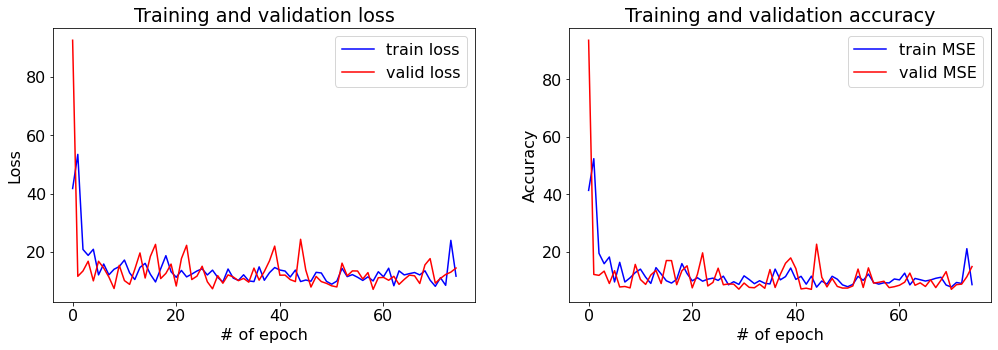

In [72]:
diabetes_model_3, history_3 = build_diabetes_model(diabetes_train_ds, diabetes_val_ds, model=model_2, epochs=100, 
                                                   optimizer='SGD')

- smaller learning rate will be tried

Train for 3 steps, validate for 1 steps
Epoch 1/100
3/3 [==============================] - 5s 2s/step - loss: 14.6549 - mse: 9.1816 - val_loss: 9.8842 - val_mse: 9.3592
Epoch 2/100
3/3 [==============================] - 0s 100ms/step - loss: 11.8858 - mse: 10.3983 - val_loss: 8.1061 - val_mse: 8.9313
Epoch 3/100
3/3 [==============================] - 0s 99ms/step - loss: 11.8243 - mse: 10.2630 - val_loss: 10.2826 - val_mse: 7.6512
Epoch 4/100
3/3 [==============================] - 0s 100ms/step - loss: 13.5202 - mse: 10.8756 - val_loss: 13.1155 - val_mse: 9.5920
Epoch 5/100
3/3 [==============================] - 0s 100ms/step - loss: 13.7601 - mse: 11.7648 - val_loss: 8.0618 - val_mse: 7.1572
Epoch 6/100
3/3 [==============================] - 0s 99ms/step - loss: 13.7573 - mse: 12.1748 - val_loss: 14.2210 - val_mse: 11.4141
Epoch 7/100
3/3 [==============================] - 0s 98ms/step - loss: 11.8603 - mse: 9.0937 - val_loss: 17.7573 - val_mse: 15.5158
Epoch 8/100
3/3 [==============

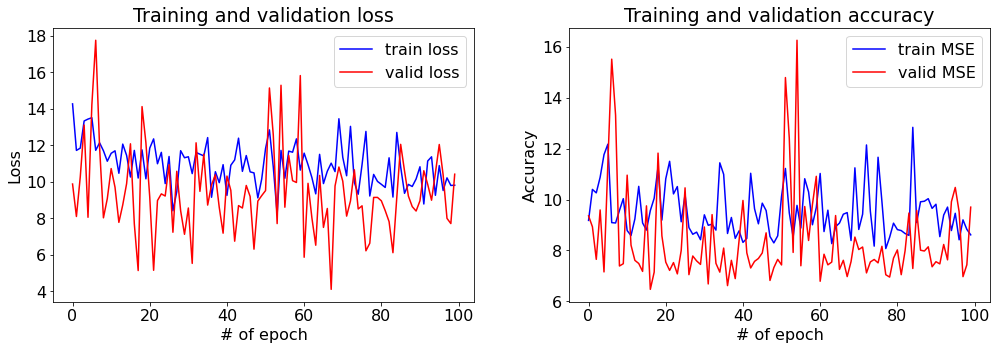

In [73]:
optimizer_4 = tf.keras.optimizers.SGD(learning_rate=0.001)
diabetes_model_4, history_4 = build_diabetes_model(diabetes_train_ds, diabetes_val_ds, model=model_2, epochs=100, 
                                                   optimizer=optimizer_4)

Model 3 with momentum will be tried.

Train for 3 steps, validate for 1 steps
Epoch 1/500
3/3 [==============================] - 5s 2s/step - loss: 9.8199 - mse: 8.8421 - val_loss: 6.5309 - val_mse: 6.7202
Epoch 2/500
3/3 [==============================] - 0s 96ms/step - loss: 10.6654 - mse: 8.1912 - val_loss: 9.2771 - val_mse: 7.3758
Epoch 3/500
3/3 [==============================] - 0s 101ms/step - loss: 10.0880 - mse: 9.0935 - val_loss: 6.9791 - val_mse: 6.8301
Epoch 4/500
3/3 [==============================] - 0s 103ms/step - loss: 10.0243 - mse: 9.6175 - val_loss: 8.0372 - val_mse: 7.3905
Epoch 5/500
3/3 [==============================] - 0s 102ms/step - loss: 8.6637 - mse: 8.5492 - val_loss: 8.4556 - val_mse: 6.8811
Epoch 6/500
3/3 [==============================] - 0s 97ms/step - loss: 10.9642 - mse: 8.6600 - val_loss: 7.2002 - val_mse: 6.7036
Epoch 7/500
3/3 [==============================] - 0s 102ms/step - loss: 11.5546 - mse: 9.9859 - val_loss: 10.4305 - val_mse: 7.8551
Epoch 8/500
3/3 [=========================

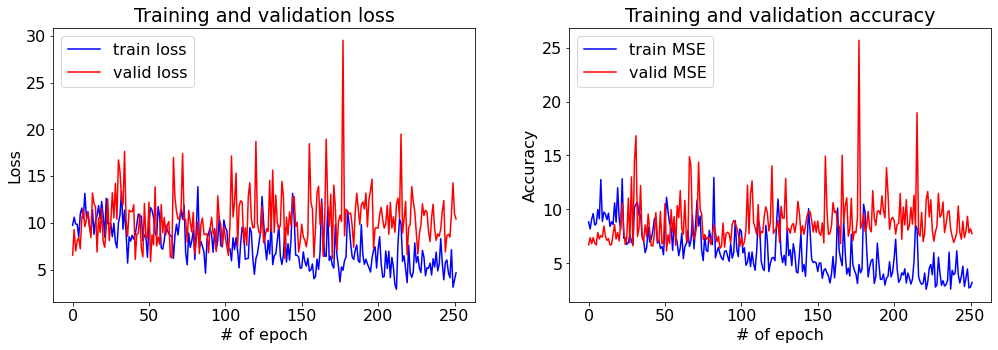

In [74]:
optimizer_5 = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.1)
diabetes_model_5, history_5 = build_diabetes_model(diabetes_train_ds, diabetes_val_ds, model=model_2, epochs=500, 
                                                   optimizer=optimizer_5)

Adding momentum did not lower the MSE significantly, this is why for evaluation model 3 will be chosen.

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [75]:
# this is on the basis of my Pneumonia detection project:
## https://github.com/SylwiaNowakowska/Chest_X_ray_Pneumonia_detection/blob/main/2%20Build%20and%20train%20model.ipynb

def plot_prediction_distribution(pred_array):
    """
    Function plotting the distribution of predictions.
    
    Args:
        pred_array (numpy array): array containing predictions
    """
    plt.figure(figsize=(6,4))
    plt.hist(pred_array, bins=50)
    plt.title('Distribution of model predictions')
    plt.xlabel('Prediction: Number of days in a hospital')
    plt.ylabel('# number of scans')
    plt.show()
    print(f'Model prediction min: {pred_array.min():.3}')
    print(f'Model prediction max: {pred_array.max():.3}')

In [76]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model_3(diabetes_x_tst)
preds = diabetes_model_3.predict(diabetes_test_ds)

In [77]:
diabetes_yhat

<tfp.distributions.Normal 'sequential_1/distribution_lambda_1/Normal/' batch_shape=[119, 1] event_shape=[] dtype=float32>

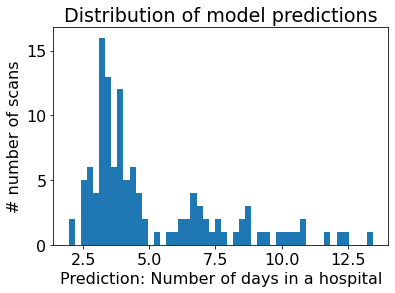

Model prediction min: 1.94
Model prediction max: 13.5


In [78]:
plot_prediction_distribution(preds)

In [79]:
m, s = get_mean_std_from_preds(diabetes_yhat)

In [80]:
m[0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[9.2593775],
       [6.619766 ],
       [7.749549 ],
       [5.4548187],
       [3.2754831],
       [6.395236 ],
       [4.0207024],
       [3.9443264],
       [3.6186638],
       [3.2754831]], dtype=float32)>

In [81]:
s[0:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.7008732 ],
       [0.6974291 ],
       [0.6989078 ],
       [0.69617724],
       [0.6929139 ],
       [0.69710135],
       [0.6943763 ],
       [0.6942666 ],
       [0.6932453 ],
       [0.6929139 ]], dtype=float32)>

## Show Prediction Output 

In [82]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values, 
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

 # I have commented the line in the utilis.py function df_to_dataset, 
    ## which shuffles the tensorflow dataset, then the actual_value is defined correctly

In [83]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,9.367129,10.0,9.259377,0.700873
1,8.470629,3.0,6.619766,0.697429
2,9.783852,5.0,7.749549,0.698908
3,6.601943,8.0,5.454819,0.696177
4,3.795172,4.0,3.275483,0.692914


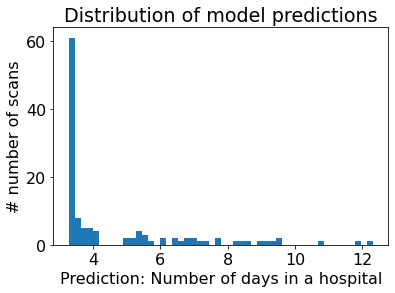

Model prediction min: 3.28
Model prediction max: 12.3


In [84]:
plot_prediction_distribution(prob_output_df['pred_mean'])

## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [85]:
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')
student_binary_prediction

array([1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.])

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [86]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [87]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,100654011,Female,Caucasian,10.0,1.0,1
1,63813420,Male,Caucasian,3.0,1.0,0
3,108730161,Male,Caucasian,5.0,1.0,1
5,3749778,Female,Caucasian,8.0,1.0,1
6,63002484,Male,Caucasian,4.0,0.0,0


In [88]:
pred_test_df.to_pickle('Pred_test_df.pkl')

## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [89]:
# this is on the basis of my Pneumonia detection project:
## https://github.com/SylwiaNowakowska/Chest_X_ray_Pneumonia_detection/blob/main/2%20Build%20and%20train%20model.ipynb

def plot_AUROC(df_col_label, df_col_pred):  
    
    plt.figure(figsize=(6,4))
    fpr, tpr, thresholds = roc_curve(df_col_label, df_col_pred)
    plt.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % ('Length of hospital stay', auc(fpr, tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Random choice')
    plt.legend(loc=2)
    plt.show()
    
    return fpr, tpr, thresholds


def plot_precision_recall_curve(df_col_label, df_col_pred):

    plt.figure(figsize=(6,4))
    plt.rcParams.update({'font.size':16})
    precision, recall, thresholds = precision_recall_curve(df_col_label, df_col_pred)
    plt.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Length of hospital stay', average_precision_score(df_col_label, df_col_pred)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc=2)
    plt.show()

In [90]:
print(classification_report(pred_test_df['label_value'], pred_test_df['score']))

              precision    recall  f1-score   support

           0       0.67      0.81      0.74        69
           1       0.64      0.46      0.53        50

    accuracy                           0.66       119
   macro avg       0.66      0.64      0.64       119
weighted avg       0.66      0.66      0.65       119



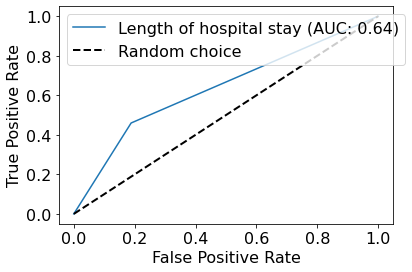

In [91]:
Fig_AUROC = plot_AUROC(pred_test_df['label_value'], pred_test_df['score'])

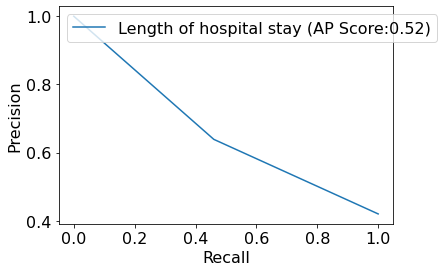

In [92]:
Fig_precision_recall = plot_precision_recall_curve(pred_test_df['label_value'], pred_test_df['score'])

- Recall (also sensitivity and true positive rate) is the ability of the model to identify the positive cases from all positive cases: i.e. to correctly identify a patient for the drug testing from all eligible ones.
- Precision (also positive predictive value) is a measure telling, if model identifies patient as eligible for the drug testing, what is the probability the patient is in fact eligible. 
- True Negatives are patients who are not eligible for drug testing and are also identified by the model as not eligible. False Negatives are patients who are eligible, but identified by the model as not.
- The current model needs to be optimized in order to increase the precision and recall. Currently the precision amounts to 0.60 (meaning that only 60% of patients identified as eligible, will be in fact eligible) and the recall to 0.68 (meaning only 68% of eligible patients will be chosen). 
- In the current business context, it is more important to correctly identify the eligible patients: i.e. to have a high recall. In case the patient will be ready for discharge, his/her hospital will not needed to be prolonged, thus generating more cost. The levels of precision and recall can be decided upon financial funds to pay for prolonged stay in the hospital of patients.

Presion-recall trade-off:
- By changing the treshold determining which class is positive, which negative the precision and recall will change in the oposite directions.

Areas of improvement for future iterations:
- Tuning model architecture by changing the number of layers and neurons
- Hyperparamter tuning: i.e. optimizer, learning rate, adding/removing momentum
- Choosing different features.

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [93]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


model_id, score_thresholds 1 {'rank_abs': [36]}


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [94]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [95]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

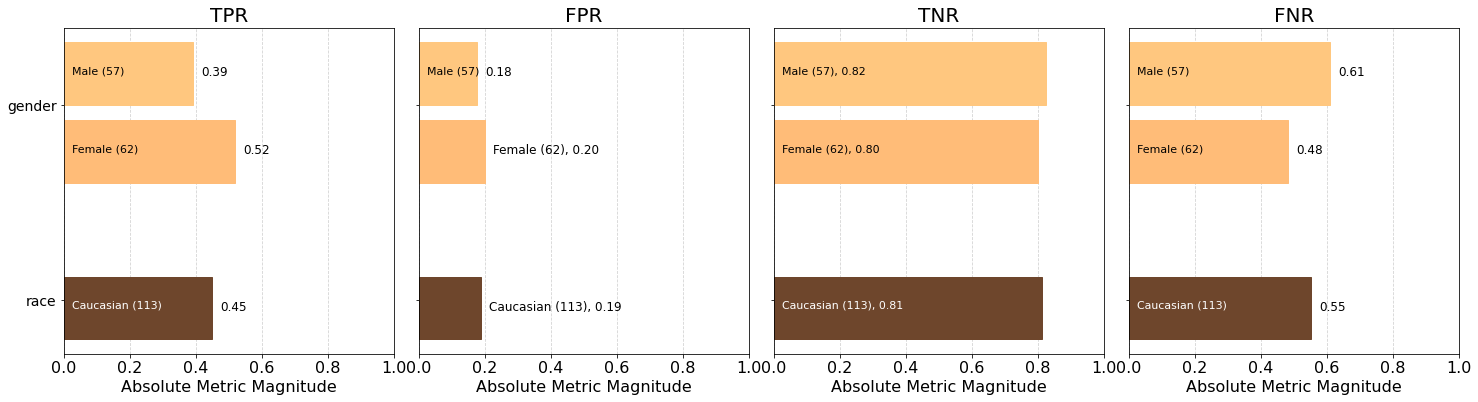

In [96]:
Fig_Aequitas_1 = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'tnr', 'fnr'], ncols=4, min_group_size=0.1)

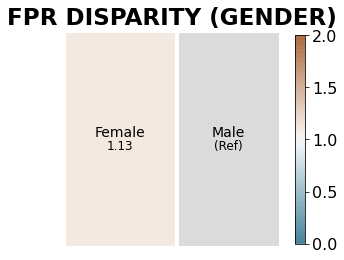

In [97]:
Fig_Aequitas_2 = aqp.plot_disparity(bdf, group_metric='fpr_disparity', attribute_name='gender', significance_alpha=0.05)

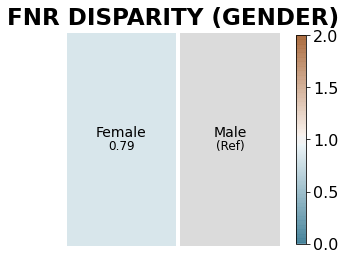

In [98]:
Fig_Aequitas_3 = aqp.plot_disparity(bdf, group_metric='fnr_disparity', attribute_name='gender', significance_alpha=0.05)

Two important metrics for patient selection are: FNR and FPR
- Female patients have higher FPR than male patients, whereas in case FNR the situation is reversed.
- As other races are underrepresented in the test dataset, no conclusion can be drawn for model bies with respect to race.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

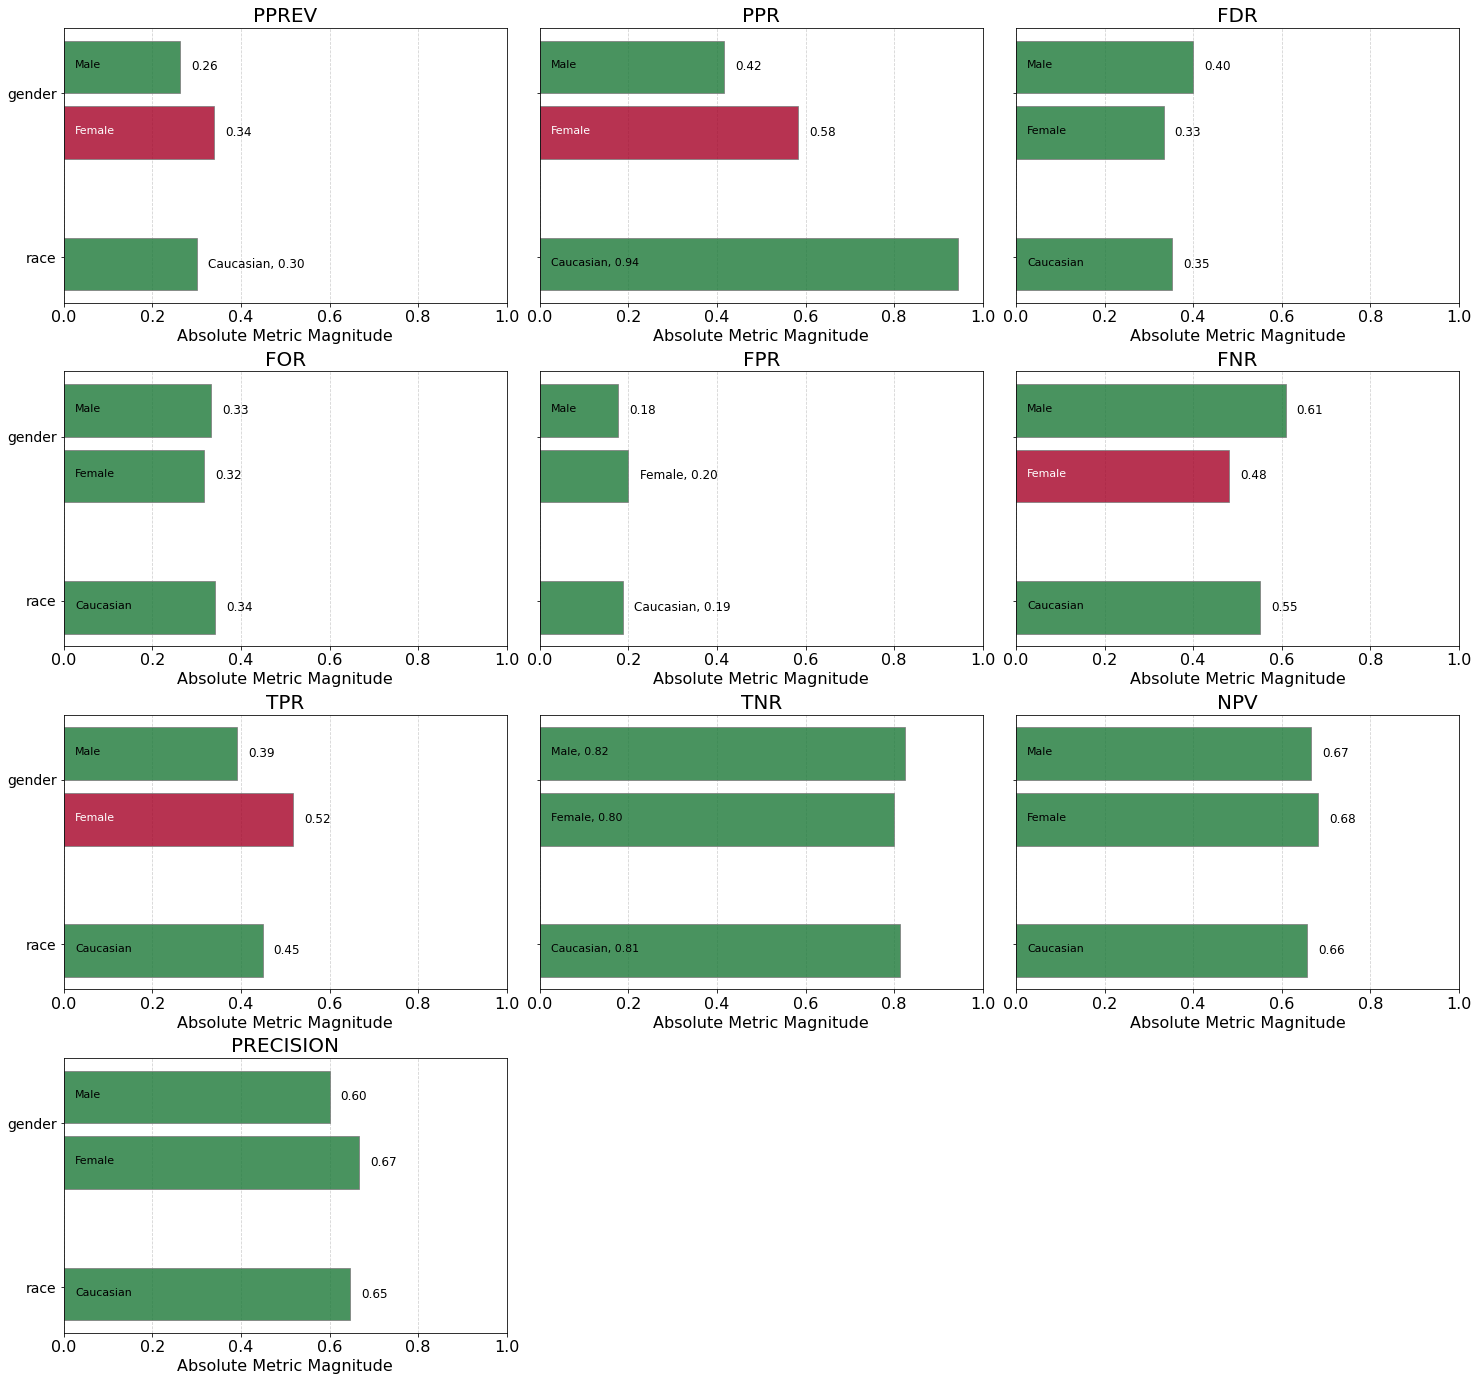

In [99]:
# Reference group fairness plot
Fig_Aequitas_4 = aqp.plot_fairness_group_all(fdf, ncols=3, metrics='all', min_group_size=0.1)

- In all metrics the Male Caucasian group has positive fairness values.